# Toil Recompute Concordance
Author: John Vivian <br>
Date: 2-23-16

Goal: Demonstrate concordance at the dataset level by random sampling genes and patients within the old TCGA RNA-seq pipeline relative to the Toil CGL pipeline.

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [72]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
sns.set_style('darkgrid')

Load in the Xena Python API library

In [3]:
from xena_query import *

## Preparation
Gather a pool of samples and gene names to randomly select from.

In [11]:
samples = dataset_samples('https://genome-cancer.ucsc.edu:443/proj/public/xena', 
                          "public/TCGA/TCGA.PANCAN.sampleMap/HiSeqV2")
print ', '.join(samples[:5])

TCGA-S9-A7J2-01, TCGA-G3-A3CH-11, TCGA-EK-A2RE-01, TCGA-44-6778-01, TCGA-VM-A8C8-01


In [115]:
genes = dataset_field('https://genome-cancer.ucsc.edu:443/proj/public/xena', 
                      "public/TCGA/TCGA.PANCAN.sampleMap/HiSeqV2")
print ', '.join(genes[200:210])

ACP5, ACP6, ACPL2, ACPP, ACPT, ACR, ACRBP, ACRC, ACRV1, ACSBG1


In [32]:
tcga_hub = "https://genome-cancer.ucsc.edu:443/proj/public/xena"
tcga_dataset = "public/TCGA/TCGA.PANCAN.sampleMap/HiSeqV2"
toil_hub = "http://ec2-54-183-152-154.us-west-1.compute.amazonaws.com:7222"
toil_dataset = "tcga_RSEM_Hugo_norm_count"

## Random Sampling
We'll randomly select 10,000 samples and 10,000 genes. These sample/gene pairs will comprise the set we'll use to construct a matrix to plot concordance.  We can even sample with replacement as it is unlikely the same sample will be paired with the same gene, given there are ~$2.2e{10^8}$ possible pairs. 

In [46]:
random_samples = np.random.choice(samples, 10000, replace=True)

In [47]:
random_genes = np.random.choice(genes, 10000, replace=True)

In [48]:
pairs = zip(random_samples, random_genes)

Query the Xena browser for the values associated with each sample-gene pairing

In [73]:
pairings = []
for i in tqdm(xrange(10000)):
    pair = '_'.join(pairs[i])
    tcga_value = dataset_probe_values(tcga_hub, tcga_dataset, [str(pairs[i][0])], [str(pairs[i][1])])[0][0]
    toil_value = dataset_probe_values(toil_hub, toil_dataset, [str(pairs[i][0])], [str(pairs[i][1])])[0][0]
    pairings.append([pair, tcga_value, toil_value])

In [76]:
df = pd.DataFrame(pairings, columns=['Sample_Gene', 'TCGA', 'Toil'])

In [104]:
df_drop = df[df.Toil != 'NaN']

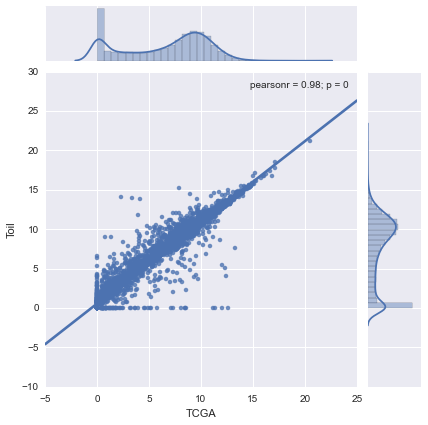

In [110]:
sns.jointplot(x='TCGA', y='Toil', data=df_drop, kind='reg');
plt.savefig('Random_sampling_concordance.png', type='png', dpi=300)